In [12]:
import pyarrow as pa
import pyarrow.parquet as pq

import pandas as pd

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from ipywidgets import interact
import numpy as np

# Actors

In [17]:
actors = pq.read_table("data/actors.parquet")
actors_df = actors.to_pandas()

actors_df

,id,uri,label,jurisdictions,categories
0,bilaxy,bilaxy.com,Bilaxy,HK,exchange
1,banxa,banxa.com,Banxa,"AU, NL, US",exchange
2,aax,www.aax.com,Aax,SC,exchange
3,altcointrader,www.altcointrader.co.za,AltcoinTrader,ZA,exchange
4,azbit,azbit.com,Azbit,MH,exchange
...,...,...,...,...,...
309,stocksexchange,stex.com,Stex,EE,exchange
310,smenarnabitcoin,smenarnabitcoin.cz,Smenarnabitcoin,CZ,exchange
311,xapo,xapo.com,Xapo,US,"exchange, service"
312,yobit,yobit.net,YoBit,RU,exchange


Lets see how the jurisdictions are "distributed"

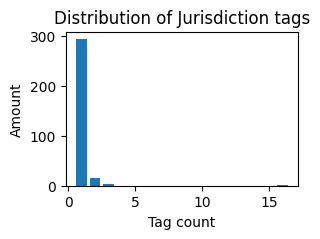

1     294
2      16
3       3
16      1
Name: jurisdictions, dtype: int64

In [21]:
# Compute the comma count for each value in the "jurisdictions" column
comma_count_stats = actors_df['jurisdictions'].apply(lambda x: str(x).count(',')+1).value_counts().sort_index()


plt.figure(figsize=(3, 2)) 
plt.bar(comma_count_stats.index, comma_count_stats.values)
plt.xlabel('Tag count')
plt.ylabel('Amount')
plt.title('Distribution of Jurisdiction tags')
plt.show()

comma_count_stats

who has 16 jurisdictions????

In [22]:
actors_df[actors_df['jurisdictions'].str.count(',') == 15]


,id,uri,label,jurisdictions,categories
35,binance,binance.com,"Binance (US, DEX)","AE, AU, BH, CA, CY, ES, FR, IT, KY, KZ, LT, MT...","defi_dex, exchange, mining_service, organization"


In [23]:
actors_df[actors_df['id'].str.contains("binance")== True]

,id,uri,label,jurisdictions,categories
35,binance,binance.com,"Binance (US, DEX)","AE, AU, BH, CA, CY, ES, FR, IT, KY, KZ, LT, MT...","defi_dex, exchange, mining_service, organization"


of course its binance LOL

# Flows

In [24]:
flows = pq.read_table("data/flows.parquet")
flows_df = flows.to_pandas()

flows_df

,src_id,dst_id,value_asset,value_USD,date
0,1coin,1coin,36870000,243.755870,2014-03-03
1,1coin,1coin,380120000,2378.899210,2014-03-10
2,1coin,1coin,429150403,2738.687542,2014-03-13
3,1coin,1coin,333900098,2092.574397,2014-03-14
4,1coin,1coin,779334803,4938.373652,2014-03-15
...,...,...,...,...,...
1939582,zyado,zyado,1019592,11.368847,2017-03-21
1939583,zyado,zyado,1004152,13.325487,2017-04-29
1939584,zyado,zyado,39850720,5966.967603,2018-01-10
1939585,zyado,zyado,19251202,1730.115174,2018-04-27


In which timeframe was the data collected?

In [25]:
# Flow data from - to
print(f'Flow data recorded from {flows_df.date.min()} to {flows_df.date.max()}')

Flow data recorded from 2011-05-13 to 2023-04-12


In [26]:
print(f'Flows before merging actor data {flows_df.shape[0]}')
merged_df = pd.merge(flows_df, actors_df.add_prefix('src_'), on='src_id', how='inner')
merged_df = pd.merge(merged_df, actors_df.add_prefix('dst_'), on='dst_id', how='inner')
print(f'Flows after merging actor data {merged_df.shape[0]}')
display(merged_df.head())

Flows before merging actor data 1939587
Flows after merging actor data 1904481


,src_id,dst_id,value_asset,value_USD,date,src_uri,src_label,src_jurisdictions,src_categories,dst_uri,dst_label,dst_jurisdictions,dst_categories
0,1coin,1coin,36870000,243.755870,2014-03-03,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
1,1coin,1coin,380120000,2378.899210,2014-03-10,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
2,1coin,1coin,429150403,2738.687542,2014-03-13,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
3,1coin,1coin,333900098,2092.574397,2014-03-14,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange
4,1coin,1coin,779334803,4938.373652,2014-03-15,1coin.io,1Coin,"CA, US",exchange,1coin.io,1Coin,"CA, US",exchange


In [27]:
# Types
merged_df['date'] = pd.to_datetime(merged_df['date'])

In [28]:
# Create list for jurisdictions
merged_df = merged_df.assign(src_jurisdictions=merged_df.src_jurisdictions.str.split(','))
merged_df = merged_df.assign(dst_jurisdictions=merged_df.dst_jurisdictions.str.split(','))
# Create year column
merged_df['year'] = merged_df.date.dt.year
# Create separate columns for each jurisdiction (if we want to split the amounts we have to split amount before)
merged_df = merged_df.explode('dst_jurisdictions')
merged_df = merged_df.explode('src_jurisdictions')
# Remove flows which aren't x-border
merged_df = merged_df[merged_df['dst_jurisdictions'] != merged_df['src_jurisdictions']]
# Grouping
dst_amounts = merged_df.groupby(['year', 'dst_jurisdictions'])['value_USD'].sum().reset_index()
src_amounts = merged_df.groupby(['year', 'src_jurisdictions'])['value_USD'].sum().reset_index()

display(dst_amounts.sort_values("value_USD",ascending=False))
display(src_amounts.sort_values("value_USD",ascending=False))

,year,dst_jurisdictions,value_USD
461,2021,MT,2.942812e+12
468,2021,US,2.900601e+12
449,2021,CA,2.893030e+12
448,2021,BH,2.893030e+12
458,2021,KY,2.893030e+12
...,...,...,...
8,2011,CZ,7.064849e+01
2,2011,SK,7.064849e+01
94,2014,ZA,4.885068e+01
5,2011,BR,2.937990e+01


,year,src_jurisdictions,value_USD
448,2021,MT,2.988312e+12
455,2021,US,2.931649e+12
458,2021,AE,2.928324e+12
457,2021,ZA,2.921904e+12
439,2021,FR,2.921904e+12
...,...,...,...
357,2019,TW,4.128866e+01
441,2021,HK,2.174110e+01
555,2022,LT,9.084283e-01
371,2020,HK,7.748544e-01


In [38]:
# Merge GDP Data

# Load country codes (source: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes)
country_codes = pd.read_csv('data/country_codes.csv')
display(country_codes.head())

# Load GDP data (PPP) (Source: https://data.worldbank.org/indicator/NY.GDP.PCAP.PP.CD)
gdp = pd.read_csv('data/gdp.csv', skiprows=3)
display(gdp.head())

gdp_meta = pd.read_csv('data/gdp_meta.csv')
display(gdp_meta.head())


set(merged_df.dst_jurisdictions.unique().tolist() + merged_df.src_jurisdictions.unique().tolist())

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,Unnamed: 67
0,Aruba,ABW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,36846.848285,37343.912963,37583.840323,38865.188195,41679.238190,42501.641554,34971.009913,42698.359872,NaN,NaN
1,Africa Eastern and Southern,AFE,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3470.550675,3498.125396,3591.099809,3635.564622,3724.868177,3777.972368,3621.058106,3839.470058,NaN,NaN
2,Afghanistan,AFG,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2110.829568,2128.125938,2023.834656,2096.093111,2109.929296,2167.704111,2076.138380,1665.805842,NaN,NaN
3,Africa Western and Central,AFW,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,4143.177054,4075.994459,3998.951876,4045.303263,4160.540965,4264.731035,4174.504565,4409.450961,NaN,NaN
4,Angola,AGO,"GDP per capita, PPP (current international $)",NY.GDP.PCAP.PP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,8123.048065,7274.090475,7027.146634,7216.061373,7042.923829,6881.076241,6362.636076,6491.125578,NaN,NaN


,Country Code,Region,IncomeGroup,SpecialNotes,TableName,Unnamed: 5
0,ABW,Latin America & Caribbean,High income,NaN,Aruba,NaN
1,AFE,NaN,NaN,"26 countries, stretching from the Red Sea in t...",Africa Eastern and Southern,NaN
2,AFG,South Asia,Low income,The reporting period for national accounts dat...,Afghanistan,NaN
3,AFW,NaN,NaN,"22 countries, stretching from the westernmost ...",Africa Western and Central,NaN
4,AGO,Sub-Saharan Africa,Lower middle income,The World Bank systematically assesses the app...,Angola,NaN


{' AU',
 ' BH',
 ' CA',
 ' CN',
 ' CY',
 ' ES',
 ' FR',
 ' GB',
 ' HK',
 ' IL',
 ' IT',
 ' KR',
 ' KY',
 ' KZ',
 ' LT',
 ' MT',
 ' NL',
 ' NZ',
 ' PL',
 ' SC',
 ' SG',
 ' SK',
 ' TR',
 ' US',
 ' VG',
 ' ZA',
 'AE',
 'AG',
 'AR',
 'AT',
 'AU',
 'AZ',
 'BE',
 'BR',
 'BS',
 'BZ',
 'CA',
 'CH',
 'CN',
 'CY',
 'CZ',
 'DE',
 'DK',
 'EE',
 'FI',
 'FR',
 'GB',
 'GE',
 'GI',
 'HK',
 'HR',
 'ID',
 'IE',
 'IL',
 'IN',
 'IR',
 'IT',
 'JP',
 'KN',
 'KR',
 'KY',
 'LT',
 'LU',
 'MH',
 'MT',
 'MX',
 'NG',
 'NL',
 'NO',
 'NZ',
 None,
 'PA',
 'PL',
 'PT',
 'RU',
 'SC',
 'SG',
 'SK',
 'TH',
 'TR',
 'TW',
 'US',
 'VC',
 'VG',
 'VN',
 'VU',
 'ZA'}